Reading in the human LR scores & retreiving LRs which have significant spots on border.

    INPUT: * data/scanpy_h5ads/MB_*_all-human_LRResults.h5ad
           * data/scanpy_h5ads/integrated_border.h5ad
           * data/spot_meta/species_classify_v2/*_FetalBrain3_singleR_scores_human.txt
    OUTPUT: * data/cci/human/*_border_enriched_LRs.txt
                    
## Environment Setup

In [1]:
import os, sys
import numpy as np
import pandas as pd
import numba
import anndata as ad
import scanpy as sc
import stlearn as st
import seaborn
from sklearn.preprocessing import scale
from timeit import time
import upsetplot
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, fisher_exact

from statsmodels.stats.multitest import multipletests

# Two directories up from wherever notebook located #
work_dir = os.getcwd()+'/../../'
os.chdir(work_dir)

species = 'human'

data_dir = 'data/scanpy_h5ads/'
annot_dir = 'data/spot_meta/species_classify_v2/'
out_dir = f'data/cci/{species}/'

samples = ['A1', 'B1', 'C1', 'D1']
mode = ''

## Loading the data

In [ ]:
"""# Running significant LR spots, was run on HPC, takes some time.
################################################################################
                    # Environment setup #
################################################################################
import os, sys
import numpy as np
import pandas as pd
import numba
import scanpy as sc

import stlearn as st
from timeit import time

species = 'human' # 'both' includes all spots & looks for interactions between mouse/human
                # 'all' includes all spots but only looks for mouse-mouse & human-mouse interactions.
distance = None

n_cpus = 23
numba.set_num_threads(n_cpus) # Setting no. of threads to run in parallel, set to same as local for timing.

################################################################################
                    # Required functions #
################################################################################
def load_data(filter_type='relaxed', samp='A1', species=None):
    #Loads the MB data for testing the LR method.
    treat_map = {'A1': 'treated', 'B1': 'treated', 
                 'C1': 'untreated', 'D1': 'untreated'}
    data_dir = f'data/Visium8_{samp}_Hybrid_{treat_map[samp]}/'
    data = st.Read10X(data_dir)
    data.var_names_make_unique()
    data.var_names = np.array([var_name.replace('_', '-')
                               for var_name in data.var_names])
    st.pp.normalize_total(data)

    min_cells = int(0.05 * data.n_obs) if filter_type == 'stringent' else 3
    st.pp.filter_genes(data, min_cells=min_cells, )

    # Loading the spot meta data #
    meta_path = f'data/spot_meta/species_classify_v2/{samp}_species.txt'
    meta_data = pd.read_csv(meta_path, sep='\t', index_col=0)
    data = data[meta_data.index.values,:].copy()
    data.obs['species'] = meta_data.loc[:,'species'].astype('category')

    if species=='human':
        human_genes = [gene for gene in data.var_names if 'mm10-' not in gene]
        data = data[data.obs['species'].values != 'mouse', human_genes].copy()
    elif species == 'mouse':
        mouse_genes = [gene for gene in data.var_names if 'mm10-' in gene]
        data = data[data.obs['species'].values != 'human', mouse_genes].copy()
    elif 'human' in species:
        human_genes = [gene for gene in data.var_names if 'mm10-' not in gene]
        data= data[:,human_genes].copy()
    elif 'mouse' in species:
        mouse_genes = [gene for gene in data.var_names if 'mm10-' in gene]
        data = data[:,mouse_genes].copy()

    return data

################################################################################
                    # Loading in the data #
################################################################################
# Spatial data #
samples = ['A1', 'B1', 'C1', 'D1']
datas = [load_data(samp=samp, species=species) for samp in samples]

# The LR pairs #
lrs_ = list(st.tl.cci.load_lrs(['connectomeDB2020_lit']))+['TNF_IGF1', 'IL4_IGF1']
lrs = []
for lr_ in lrs_:
    l_, r_ = lr_.split('_')
    if species == 'human':
        lrs.append( f'hg38-{l_}_hg38-{r_}' )
    elif species == 'mouse':
        lrs.append( f'mm10-{l_[0]+l_[1:].lower()}_mm10-{r_[0]+r_[1:].lower()}' )
    elif species == 'both':
        lrs.append( f'hg38-{l_}_mm10-{r_[0]+r_[1:].lower()}' )
        lrs.append( f'mm10-{l_[0]+l_[1:].lower()}_hg38-{r_}' )
    elif species == 'all':
        lrs.append( f'hg38-{l_}_hg38-{r_}' )
        lrs.append( f'mm10-{l_[0]+l_[1:].lower()}_mm10-{r_[0]+r_[1:].lower()}' )

#lrs = np.random.choice(lrs, 20) # For testing purposes.

################################################################################
                       # Running the LR analysis #
################################################################################
mode = '' if type(distance)==type(None) else 'within-spot_'
n_pairs = 10000
for i, data in enumerate(datas):
    start = time.time()
    st.tl.cci.run(data, lrs,
                      min_spots = 1, #Filter out any LR pairs with no scores for less than x spots
                      distance=distance, #To define the spot neighbourhood
                      n_pairs=n_pairs, #Number of random pairs to generate
                      adj_method='fdr_bh', #MHT correction method
                      min_expr=0, #min expression to be considered as scored.
                      pval_adj_cutoff=.05,
                      )
    end = time.time()
    diff = end-start
    print(f'{diff} secs')
    print(f'{diff/60} mins')

    # Saving the results in the AnnData #
    if True:
        samp = samples[i]
        data.write_h5ad(gml_rdm_path+f'Brad/MB_{samp}_{species}_{mode}LRResults.h5ad',
                    compression='gzip')

"""

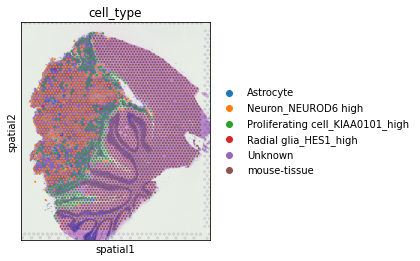

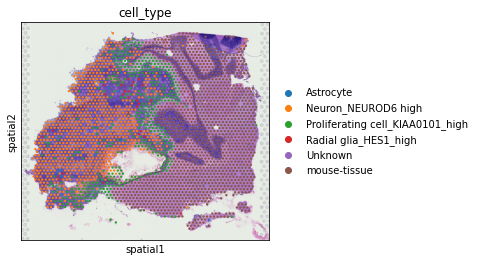

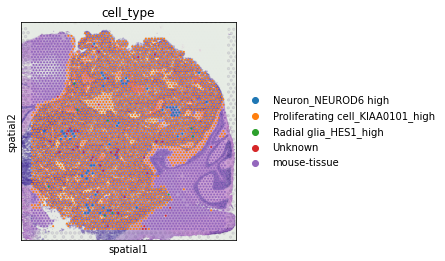

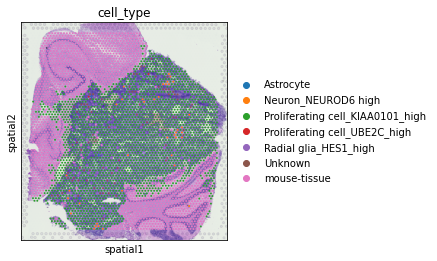

In [2]:
"""
Generated by the above; i.e. running st.tl.cci.run on the each of the datas subsetted
to mouse genes only with 10000 random pairs and lrs from running:
st.tl.cci.load_lrs() formatted with hg38- prefixes.
"""
datas = [sc.read_h5ad(data_dir+f'MB_{samp}_all-{species}_{mode}LRResults.h5ad')
         for samp in samples]

### Adding the labels & the SingleR information ###
for i, samp in enumerate(samples):
    data = datas[i]

    singler = pd.read_csv(annot_dir+
                          f'{samp}_FetalBrain3_singleR_scores_{species}.txt',
                          sep='\t', index_col=0)
    bcs = np.array( [bc.split('_')[-1] for bc in singler.index.values] )
    singler.index = bcs

    # Checking for nans, which indicate cases where low correlations #
    nan_bool = [type(label)!=str for label in singler.loc[:,'labels']]
    nan_indices = np.where( nan_bool )[0]
    # Correctly label as the highest correlation #
    best_labels = [singler.columns.values[np.nanargmax(singler.values[i])]
                   for i in nan_indices]
    singler.loc[nan_bool, ['labels']] = best_labels

    # Creating the labels, where label missing is the human-tumour #
    labels = []
    for bc in data.obs_names:
        if bc in bcs:
            labels.append( singler.loc[bc,'labels'] )
        else:
            labels.append( 'mouse-tissue' )
    labels = pd.Series(np.array(labels),
                                        index=data.obs_names).astype('category')

    # Adding the labels #
    data.obs['cell_type'] = labels

    # Visual check #
    sc.pl.spatial(data, color='cell_type')


## Loading the border information

Trying to set attribute `.uns` of view, copying.


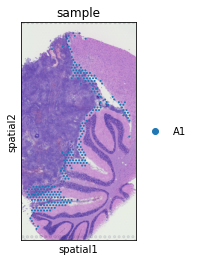

Trying to set attribute `.uns` of view, copying.


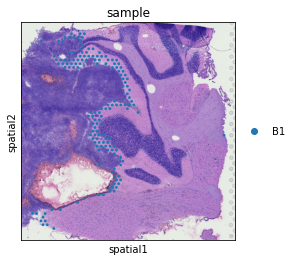

Trying to set attribute `.uns` of view, copying.


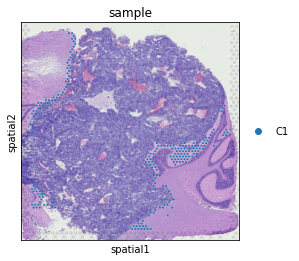

Trying to set attribute `.uns` of view, copying.


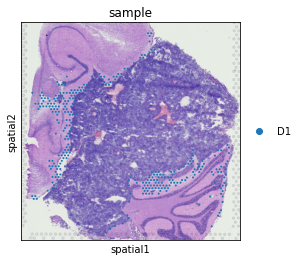

In [3]:
# Getting the barcodes of the border spots #
border_data = sc.read_h5ad('data/scanpy_h5ads/integrated_border.h5ad')
# Getting list of barcodes in each sample corresponding to the border spots #
border_bcs = {}
for samp in samples:
    border_bcs[samp] = [bc.split(f'-{samp}')[0] for bc in border_data.obs_names
                        if samp in bc]
    sc.pl.spatial(border_data[border_data.obs['sample']==samp,:], color='sample', library_id=f'Visium8_{samp}_Hybrid')

## Getting LRs with significant interactions on border

In [4]:
# Need to subset to human-mix #
data_subs = []
for data in datas:
    pure_mix = data.obs['cell_type'].values.astype(str) != 'mouse-tissue'
    data_subs.append( data[pure_mix,:].copy() )

In [5]:
###### Function gettings LRs with sig spots border ########
def lr_border_spots(datas, samples, border_bcs, min_spots=1,
                       score_key='lr_scores'):
    """Retrieves LR with minimum no. of spots on border.
    """
    de_lrs = []
    for i, data in enumerate(datas):
        # Getting the lr scores #
        lrs = data.uns['lr_summary'].index.values.astype(str)
        lr_scores = pd.DataFrame(data.obsm[score_key].transpose(),
                                 columns=data.obs_names, index=lrs)

        # Getting the border labels #
        border_bool = np.array([bc in border_bcs[samples[i]]
                                for bc in data.obs_names])
        labels = np.array(
            [' ' * max([len('border'), len('core')])] * data.shape[0])
        labels[border_bool] = 'border'
        labels[border_bool == False] = 'core'

        # Filter out pairs with minimum spots on border #
        border_spots_counts = (lr_scores.values[:, border_bool] > 0).sum(axis=1)
        lr_bool = border_spots_counts >= min_spots
        lr_scores = lr_scores.loc[lr_bool, :]
        lrs = lr_scores.index.values

        stats = pd.DataFrame(border_spots_counts[lr_bool],
                             index=lrs, columns=['border_spot_counts'])
        order = np.argsort(-stats.values[:, 0])
        stats = stats.iloc[order, :]

        de_lrs.append(stats)

    return de_lrs

In [6]:
## Retrieving any LR with significant spot on border ##
sig_dfs = lr_border_spots(data_subs, samples, border_bcs,
                              min_spots=4, score_key='lr_sig_scores',)
for i, sig_df in enumerate(sig_dfs):
    print(sig_df)
#     sig_df.to_csv(out_dir +
#                    f'{samples[i]}_border_enriched_LRs.txt', sep='\t')

                        border_spot_counts
hg38-LGALS1_hg38-ITGB1                  30
hg38-MDK_hg38-ITGB1                     23
hg38-ROBO1_hg38-ROBO1                   15
hg38-MDK_hg38-SDC3                      13
hg38-GNAI2_hg38-CNR1                    12
...                                    ...
hg38-HLA-B_hg38-CANX                     4
hg38-LAMA2_hg38-DAG1                     4
hg38-SPON2_hg38-ITGA4                    4
hg38-NDP_hg38-FZD4                       4
hg38-AGT_hg38-AGTR1                      4

[77 rows x 1 columns]
                        border_spot_counts
hg38-CADM1_hg38-CADM1                   11
hg38-PTPRK_hg38-PTPRK                    7
hg38-MDK_hg38-SDC3                       6
hg38-PTN_hg38-PLXNB2                     5
hg38-ANG_hg38-PLXNB2                     5
hg38-LGALS1_hg38-ITGB1                   4
hg38-ROBO1_hg38-ROBO1                    4
hg38-MDK_hg38-ITGB1                      4
hg38-WNT5A_hg38-FZD1                     4
hg38-MDK_hg38-SDC4             

## Visualising to look for consitency across samples with upsetplot

In [7]:
######### Functions for creating an upsetplot #########
def upset_plot(obj_lists, group_names=None, fig_title='', file_name=None,
               sort_by="cardinality", sort_groups_by=None):
    """ Creates an upset plot, a visualisation which is useful for comparing \
        overlaps between multiple groups when have more than one group.

    Args:
        obj_lists (list<list<object>>): List of items in different groups want \
                                          to generate upset-plot for to compare.
        group_names (list<str>): List of strings indicating the names for the \
                                                               different groups.
    """
    obj_lists = obj_lists[::-1]
    if type(group_names)==type(None):
        group_names = [f'group_{i}' for i in range(len(obj_lists))]
    else:
        group_names = group_names[::-1]

    upset_df = get_upset_df(obj_lists, group_names)

    upsetplot.plot(upset_df['c'], sort_by=sort_by,
                   sort_categories_by=sort_groups_by)
    plt.title(fig_title, loc='left')
    plt.show()

def get_upset_df(obj_lists, group_names):
    """ Creates the necessary input to draw an upset plot for visualising overlaps
        between multiple groups!
    Args:
        obj_lists (list<list<object>>): List of items in different groups want \
                                          to generate upset-plot for to compare.
        group_names (list<str>): List of strings indicating the names for the \
                                                               different groups.
    Returns:
        pd.DataFrame: This is a dataframe formatted in the required formatted \
                    for input to upsetplot so can visualise multi-overlaps.
    """
    all_hs_genes = []
    [all_hs_genes.extend(de_hs_) for de_hs_ in obj_lists]
    all_hs_genes = np.unique(all_hs_genes)

    de_hs_genes = obj_lists
    samples = group_names

    de_hs_vals = np.zeros((len(samples), len(all_hs_genes)))
    for i, samp in enumerate(samples):
        for j, gene in enumerate(all_hs_genes):
            if gene in de_hs_genes[i]:
                de_hs_vals[i, j] = 1
    de_hs_df = pd.DataFrame(de_hs_vals.transpose(),
                            index=all_hs_genes, columns=samples)

    upset_df = pd.DataFrame()
    col_names = samples
    for idx, col in enumerate(de_hs_df[samples]):
        temp = []
        for i in de_hs_df[col]:
            if i != 0:
                temp.append(True)
            else:
                temp.append(False)
        upset_df[col_names[idx]] = temp

    upset_df['c'] = 1
    example = upset_df.groupby(col_names).count().sort_values('c')

    return example


def get_set_overlaps(obj_lists, sub_samp_lists, group_names=None):
	"""Gets overlaps between inputted combinations of the sets. Can use the \
		upset_plot in quick_plot helpers to choose the combination of overlaps \
		to look at. Note that, will only return overlap that fits the \
		combination, meaning only intersect with that group, but not any other \
		group inputted.

	Args:
		obj_lists (list<list<object>>): List of items in different groups want \
										  to generate upset-plot for to compare.
		sub_samp_lists (list<list<int or str>>): List of lists indicating the \
									combination of overlaps to take between \
									the set; if string is referring to the \
									group_names, if int referring to index.
		group_names (list<str>): List of strings indicating the names for the \
								 different groups. If none defaults to indices \
								 of the pairs in the list.

	Returns:
		list<np.array<str>>: Each array contains the overlaps of items in the \
											 groups requested in sub_samp_lists.
	"""
	if type(group_names)==type(None):
		group_names = list(range(len(obj_lists[0])))

	commons = []
	for sub_samps in sub_samp_lists:
		init_index = np.where(np.array(group_names)==sub_samps[0])[0][0]
		common = set(obj_lists[init_index])
		for i, de_h in enumerate(obj_lists):
			if group_names[i] in sub_samps and i != init_index:
				common = common.intersection( set(obj_lists[i]) )
			elif group_names[i] not in sub_samps:
				common = common.difference( set(obj_lists[i]) )
		common = np.unique( list(common) )
		commons.append( common )

	return commons

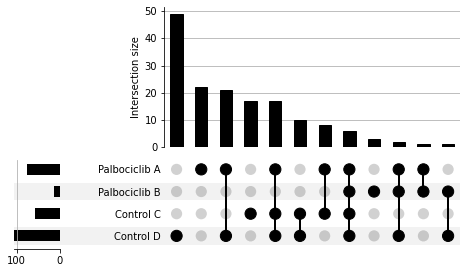

In [8]:
##### Visualising overlaps with upsetplot ########
# Significant LR pairs enriched on border in each sample #
sig_pairs = [sig_df.index.values for sig_df in sig_dfs]

# Examining the overlaps #
sample_names = ['Palbociclib A', 'Palbociclib B', 'Control C', 'Control D']
upset_plot(sig_pairs, sample_names)

In [9]:
###### Looking at what the pairs are by taking overlaps of significant LR pairs ######
# Getting genes in common between from different combinations #
interesting_overlaps = [samples, ['A1', 'B1']]
overlaps = get_set_overlaps(sig_pairs, interesting_overlaps, samples)
for i, overlap in enumerate(overlaps):
    print('_'.join(interesting_overlaps[i]), list(overlap))

A1_B1_C1_D1 ['hg38-CADM1_hg38-CADM1', 'hg38-LGALS1_hg38-ITGB1', 'hg38-MDK_hg38-ITGB1', 'hg38-MDK_hg38-SDC3', 'hg38-PTPRK_hg38-PTPRK', 'hg38-ROBO1_hg38-ROBO1']
A1_B1 ['hg38-PTN_hg38-PLXNB2']


## Spatial Visualisation of LRs pairs with significant spots in border

/Users/uqbbalde/Desktop/Uni_Studies/myPython/stlearn_latest/stLearn/stlearn/plotting/classes.py:186: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  label=color_bar_label)


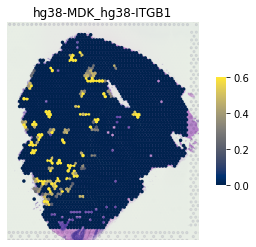

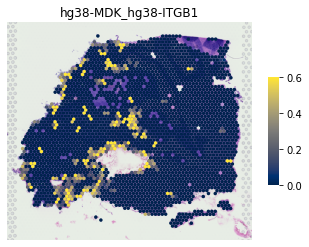

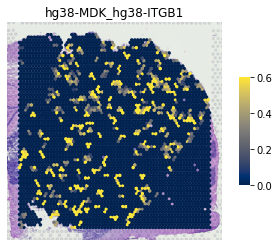

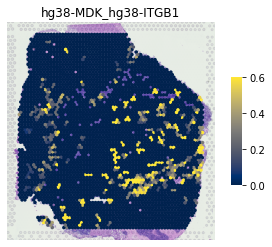

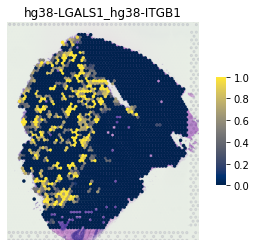

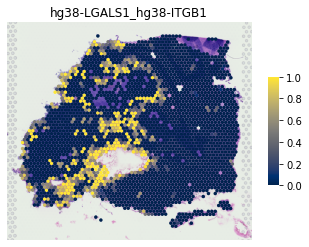

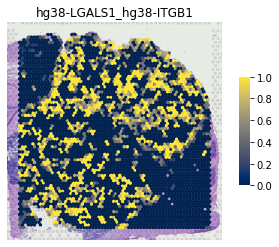

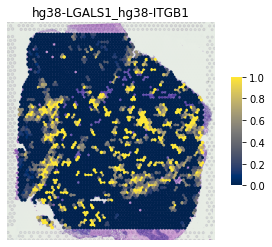

In [10]:
best_pairs = ['hg38-MDK_hg38-ITGB1', 
              'hg38-LGALS1_hg38-ITGB1']

maxs = [.6, 1, .6]
for j, lr in enumerate(best_pairs):
    for i, data in enumerate(datas):
        samp = samples[i]

        st.pl.lr_result_plot(data, use_result='lr_scores', use_lr=lr,
                             vmax=maxs[j], cmap='cividis', size=12)
        plt.show()


## Looking at interesting LR pairs stratified by tumour core and interface

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


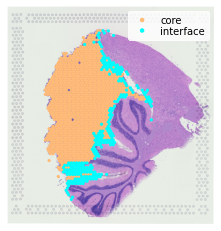

Trying to set attribute `.obs` of view, copying.


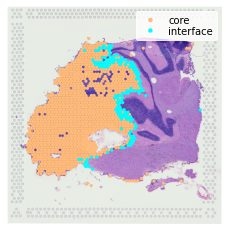

Trying to set attribute `.obs` of view, copying.


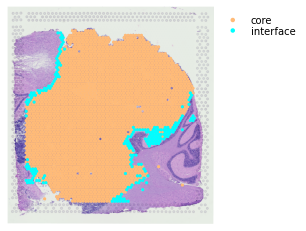

Trying to set attribute `.obs` of view, copying.


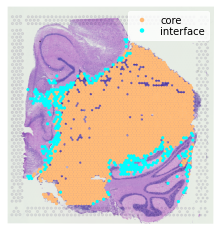

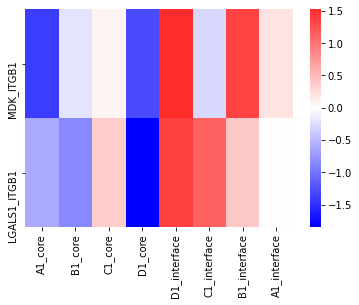

In [11]:
################################################################################
      # Making heatmap to summarise the LR scores across core/interface #
################################################################################
lrs = ['hg38-MDK_hg38-ITGB1','hg38-LGALS1_hg38-ITGB1']
lrs_ = [lr_.replace('hg38-','') for lr_ in lrs]
lr_score_mat = np.zeros((len(lrs), 2*len(datas)))
colnames = ['']*lr_score_mat.shape[1]
for i, lr in enumerate(lrs):
    coli = 0
    for j, samp in enumerate(samples):
        data = datas[j]
        keep_bool = np.logical_or(data.obs['species']=='human',
                                  data.obs['species']=='mix')
        data = data[keep_bool, :]

        # Retrieving the LR information #
        lr_index = np.where(data.uns['lr_summary'].index.values == lr)[0][0]
        lr_scores = data.obsm['lr_scores'][:, lr_index]

        # Getting the border labels #
        bcs = data.obs_names
        border_labels = np.array(['interface' if bc in border_bcs[samp] else 'core'
                                                                 for bc in bcs])
        data.obs['border'] = border_labels
        data.obs['border'] = data.obs['border'].astype('category')

        # Getting the mean of the lrs #
        border_mean = np.mean(lr_scores[border_labels=='interface'])
        core_mean = np.mean(lr_scores[border_labels=='core'])
        col_b, col_c = coli, -coli-1
        lr_score_mat[i, col_b] = core_mean
        lr_score_mat[i, col_c] = border_mean

        if i == 1:
            colnames[col_b] = f'{samp}_core'
            colnames[col_c] = f'{samp}_interface'
            # Plotting the spatial labels of core/interface #
            data.uns['border_colors'] = ['#00FFFF', '#FFBB78'][::-1]
            st.pl.cluster_plot(data, use_label='border', size=10, crop=False,
                               )
            plt.show()

        coli += 1
lr_score_mat_scaled = scale(lr_score_mat, axis=1)
lr_score_df = pd.DataFrame(lr_score_mat_scaled, index=lrs_, columns=colnames)

ax = seaborn.heatmap(lr_score_df, cmap='bwr', center=0)
plt.show()